In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from resnet18_32x32 import ResNet18_32x32


from torchvision import transforms
from sklearn.manifold import TSNE

In [5]:
# 加载训练好的模型
model = ResNet18_32x32()
model.load_state_dict(torch.load('./resnet/model.pth'))
output = "./output_prob"


# 加载CIFAR-10数据集
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=2)
# 加载训练集和测试集
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=False, num_workers=2)


# 使用模型预测类别概率分布
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


Files already downloaded and verified
Files already downloaded and verified


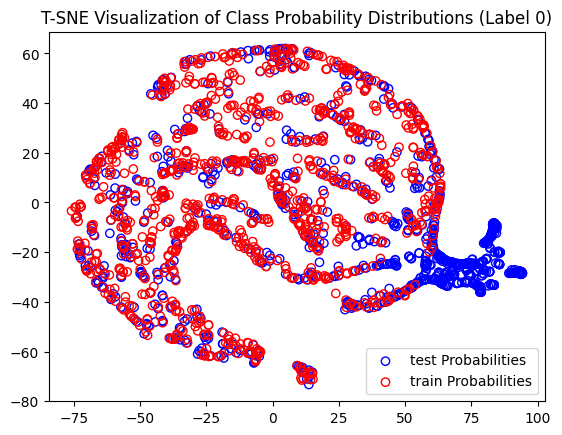

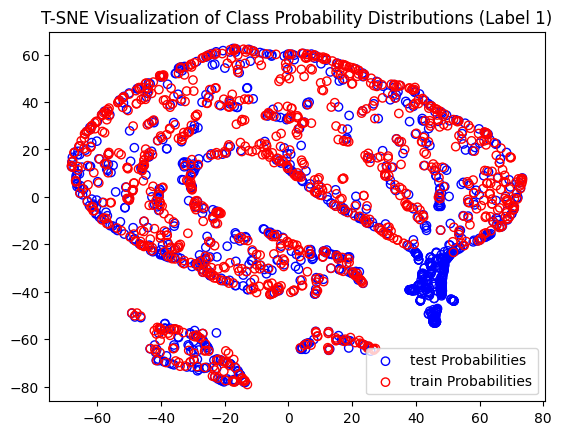

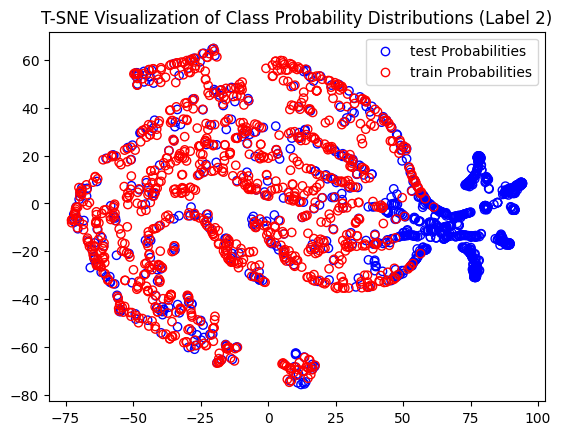

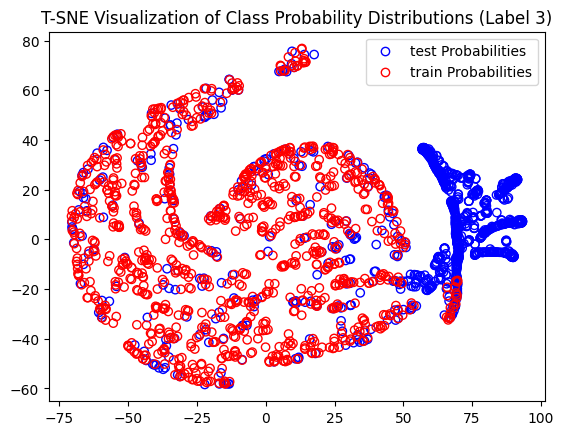

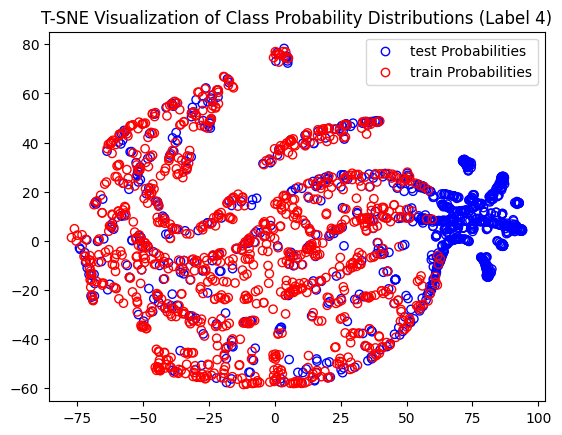

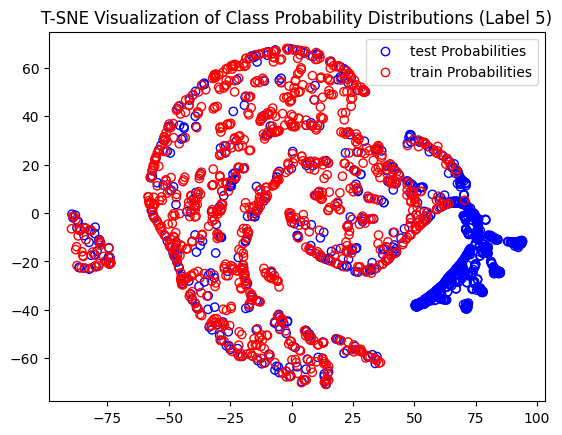

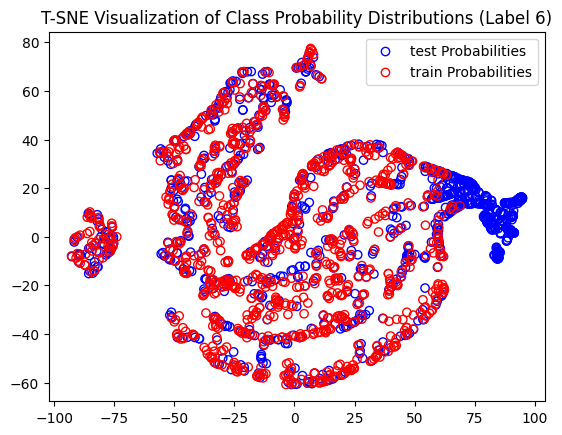

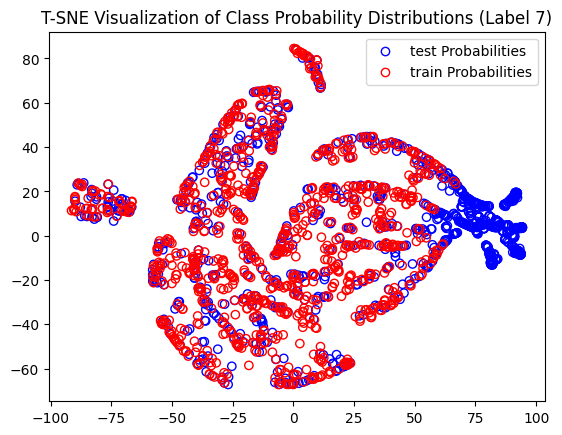

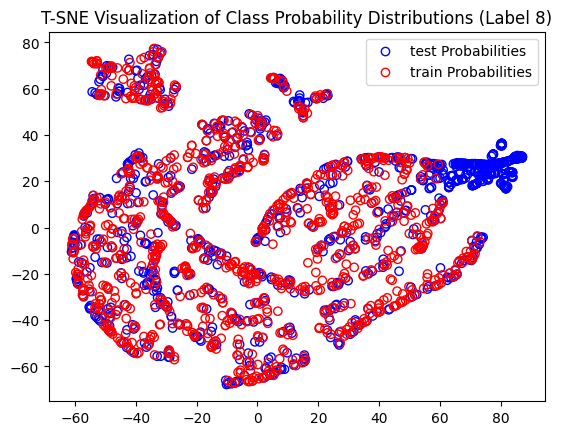

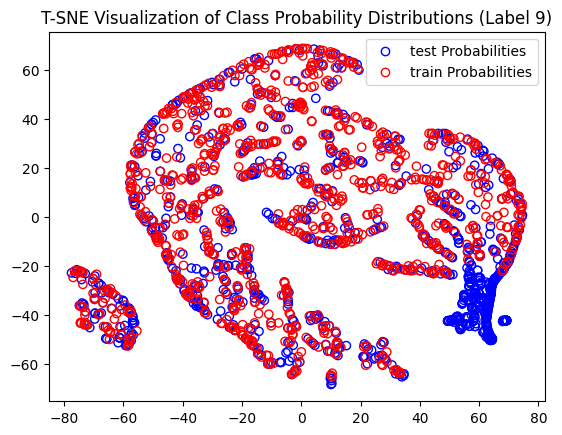

In [13]:


for number in range(10):
    # 将模型设置为评估模式
    # 创建空列表存储类别概率分布
    test_probs = []
    train_probs = []
    model.eval()
    # 禁用梯度计算
    with torch.no_grad():
        # 处理测试集
        for images, labels in testloader:
            if labels.item() == number:
                images = images.to(device)
                labels = labels.to(device)
                
                # 输入模型并获取输出
                outputs = model(images)
                
                # 使用 softmax 函数将输出转换为类别概率分布
                probabilities = torch.softmax(outputs, dim=1)
                
                # 将类别概率分布添加到列表中
                test_probs.append(probabilities.cpu().numpy()[0])
        
        # 处理训练集
        count = 0
        for images, labels in trainloader:
            if labels.item() == number:
                images = images.to(device)
                outputs = model(images)
                probabilities = torch.softmax(outputs, dim=1)
                train_probs.append(probabilities.cpu().numpy()[0])
                
                count += images.size(0)
                
                if count >= 10000:
                    break
    
    # 将类别概率分布转换为 NumPy 数组
    test_probs = np.array(test_probs)
    
    
    train_probs = np.array(train_probs)
    
    
    all_probs = np.concatenate((test_probs, train_probs))
    all_labels = np.concatenate((np.zeros(len(test_probs)), np.ones(len(train_probs))))    
    
    tsne = TSNE(n_components=2, random_state=42)
    embeddings = tsne.fit_transform(all_probs)
        
    # 绘制降维后的数据点
    plt.scatter(embeddings[:len(test_probs), 0], embeddings[:len(test_probs), 1], marker='o', facecolors='none', edgecolors='blue', label='test Probabilities')
    plt.scatter(embeddings[len(train_probs):, 0], embeddings[len(train_probs):, 1], marker='o', facecolors='none', edgecolors='red', label='train Probabilities')
    plt.legend()
    plt.title('T-SNE Visualization of Class Probability Distributions (Label {})'.format(number))
    plt.show()